#### Logistic Regression
> The purpose of this notebook is to explore the logistic regression algorithm and it's implementation. I plan on using the GermanCredit data set germancredit.txt from http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german / (description at http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29 ) to implement logistic regression to find a good predictive model for whether credit applicants are good credit risks or not. Because linear regression gives a result between 0 and 1, it requires setting a threshold probability to separate between “good” and “bad” answers. In this data set, they estimate that incorrectly identifying a bad customer as good, is 5 times worse than incorrectly classifying a good customer as bad which I will use for implementing the threshold.

In [37]:
# Set seed so output is reproducible
set.seed(123)

# Load libraries needed for analysis
library(ggplot2) # for plots
library(dplyr) # includes pipeline operator
library(rpart) # tree model
library(rpart.plot) # visualizing the tree model
library(rattle) # another way to visualize the tree model
library(randomForest) # random forest model
library(caret) # for performing cross-validation
library(cowplot) # for creating grid of plots
library(pROC) # creating ROC curves

To create the model I am going to use the following steps:

1) Load and explore the dataset
2) Create training and testing datasets
3) Train and optimize the logistic regression model
4) Interpret model
5) Create threshold based on part 2 of the question

#### Step 1 - Load and Explore the Dataset
The first thing I am going to do is to load the dataset and get some summary statistics to get a better idea of the data I am working with.

In [18]:
# Load the German credit data and print the head of the table to make sure it loaded correctly
credit_data <- read.table("germancredit.txt", header = FALSE)
head(credit_data)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1


In examining the dataset I started by looking at the description provided at the UC Irvine ML Repository where the data was originally taken from. It included a cost matrix that showed that the cost of classifying a customer as "good" when they are "bad" was 5x the cost of classifying a customer as "bad" when they are actually "good" which is in line with part 2 of this question. It also provided a description of all of the attributes and what each of their values means. Lastly, it provides baseline model performance for various classification algorithms. For logistic regression it has a baseline accuracy of 70% - 80.8% and precision of 64.242% - 78.042%. It also shows that a Random Forest Classification model is the best option for the dataset. I have provided a copy of the Variables Table below:

![Variables Table](Variables_table.png)

Since the original file didn't include headers I am going to add them to the dataset below. I also considered changing the attribute values to what they represent (ie A11 -> '<0', A40 -> 'car') but decided it isn't necassary for this analysis. However, if this was a model I was planning on using frequently it could be worth it to help with interpretting the results.

In [19]:
colnames(credit_data) <- c("exist_acct", "duration", "credit_hist", "purpose", "credit_amt", "savings", "employ_len", "install_rate", "status_sex", "debts", "resid_len", "prop", "age", "oth_inst", "house", "credit_cnt", "job", "liab_maint", "phone", "foreign", "decision")

Next, I want to get some summary statistics about the dataset which I'll do below. I already know that their aren't any missing values from the table above so I won't check that but I will look at the distribution of the variables.

In [20]:
summary(credit_data)

 exist_acct    duration    credit_hist    purpose      credit_amt    savings  
 A11:274    Min.   : 4.0   A30: 40     A43    :280   Min.   :  250   A61:603  
 A12:269    1st Qu.:12.0   A31: 49     A40    :234   1st Qu.: 1366   A62:103  
 A13: 63    Median :18.0   A32:530     A42    :181   Median : 2320   A63: 63  
 A14:394    Mean   :20.9   A33: 88     A41    :103   Mean   : 3271   A64: 48  
            3rd Qu.:24.0   A34:293     A49    : 97   3rd Qu.: 3972   A65:183  
            Max.   :72.0               A46    : 50   Max.   :18424            
                                       (Other): 55                            
 employ_len  install_rate   status_sex  debts       resid_len       prop    
 A71: 62    Min.   :1.000   A91: 50    A101:907   Min.   :1.000   A121:282  
 A72:172    1st Qu.:2.000   A92:310    A102: 41   1st Qu.:2.000   A122:232  
 A73:339    Median :3.000   A93:548    A103: 52   Median :3.000   A123:332  
 A74:174    Mean   :2.973   A94: 92               Mean   :2.

The dataset includes 11 categorical variables, three binary variables, and seven integers. The high number of categorical/binary variables makes me think that a CART model would be a great option since the different classes would allow for easy interpretation. Next I am going to plot the distibution of values for each of the variables to visually inspect them.

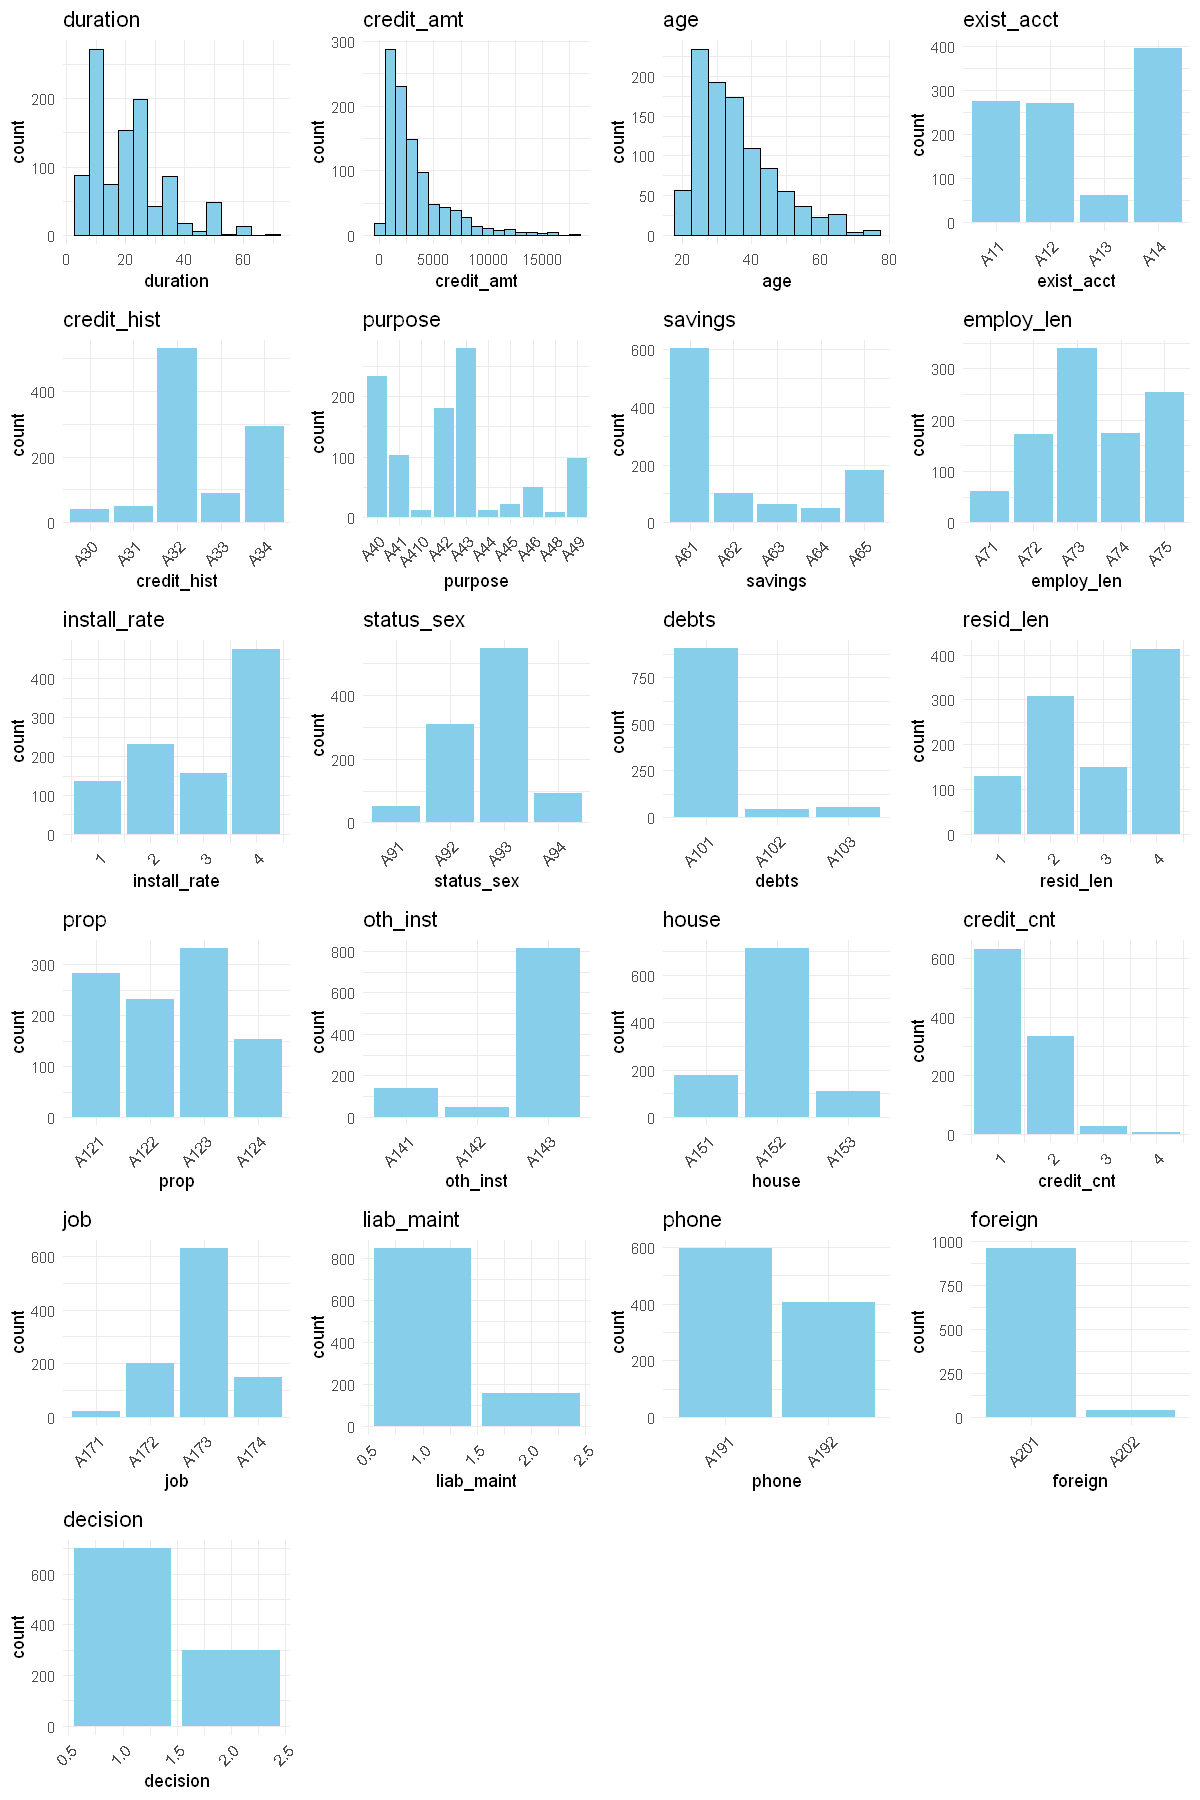

In [21]:
options(repr.plot.width=10, repr.plot.height=15)

# Define the names of columns containing categorical variables
categorical_columns <- c("exist_acct", "credit_hist", "purpose", "savings", "employ_len", "install_rate",
                         "status_sex", "debts", "resid_len", "prop", "oth_inst", "house", "credit_cnt",
                         "job", "liab_maint", "phone", "foreign", "decision")

# Define the names of columns containing numerical variables
numerical_columns <- c("duration", "credit_amt", "age")

# Plot histograms for numerical columns
num_plots <- lapply(numerical_columns, function(col) {
  if(col == "credit_amt") {
    ggplot(credit_data, aes_string(x = col)) +
      geom_histogram(binwidth = 1000, fill = "skyblue", color = "black") +
      labs(title = col) +
      theme_minimal()
  } else {
    ggplot(credit_data, aes_string(x = col)) +
      geom_histogram(binwidth = 5, fill = "skyblue", color = "black") +
      labs(title = col) +
      theme_minimal()
  }
})

# Plot histograms for categorical columns
cat_plots <- lapply(categorical_columns, function(col) {
  ggplot(credit_data, aes_string(x = col)) +
    geom_bar(fill = "skyblue") +
    labs(title = col) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
})

# Combine plots for numerical and categorical columns
all_plots <- c(num_plots, cat_plots)

# Arrange plots in a grid with four plots in each row using cowplot
plot_grid(plotlist = all_plots, ncol = 4)

One thing worth noting is the large discrepency in the number of datapoints labeled as 'good' vs. the number labeled as 'bad' which is less than half as many. It could create bias in our model towards false positives since the model will have a larger number of 'good' classifications.

#### Step 2 - Create Training and Testing Sets
Now that I have a good handle on what the data is, I'm going to partition it into training and testing sets. I am going to split the data into 70-30 for training-testing using the createDataPartition() function from the caret package. This function ensures that the split is stratified, meaning that the distribution of the dependent variable is preserved in both the training and testing sets.

In [22]:
# Create an index for the split
split_index <- createDataPartition(credit_data$decision, p = 0.7, list = FALSE)

# Split the data into training and testing sets
training_data <- credit_data[split_index, ]
testing_data <- credit_data[-split_index, ]
cat("The training data has", nrow(training_data), "rows and the mean of the of dependent variable 'decision' is", mean(training_data[,'decision']),"with a standard deviation of", sd(training_data[,'decision']), "\n")
cat("The testing data has", nrow(testing_data), "rows and the mean of the of dependent variable 'decision' is", mean(testing_data[,'decision']),"with a standard deviation of", sd(testing_data[,'decision']))

The training data has 700 rows and the mean of the of dependent variable 'decision' is 1.302857 with a standard deviation of 0.4598225 
The testing data has 300 rows and the mean of the of dependent variable 'decision' is 1.293333 with a standard deviation of 0.4560506

#### Step 3 - Train the Logistic Regression Model
I am using the binomial family because our result 'decision' has a binomial distribution. The different options for the family to use in the regression model can be found here https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/family and the details about the inputs for the glm() function can be found here https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/glm. I had to set the dependent variable 'decision' to be a factor since the binomial family expects classification values of 0 and 1.

In [23]:
credit_model <- glm(as.factor(decision) ~ ., family = binomial(link = "logit"), data=training_data)
summary(credit_model)


Call:
glm(formula = as.factor(decision) ~ ., family = binomial(link = "logit"), 
    data = training_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2564  -0.6915  -0.3310   0.5833   2.6549  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     7.982e-01  1.351e+00   0.591 0.554575    
exist_acctA12  -2.159e-01  2.719e-01  -0.794 0.427135    
exist_acctA13  -1.454e+00  4.628e-01  -3.143 0.001675 ** 
exist_acctA14  -1.805e+00  2.916e-01  -6.192 5.94e-10 ***
duration        3.659e-02  1.214e-02   3.015 0.002569 ** 
credit_histA31  3.826e-01  7.314e-01   0.523 0.600946    
credit_histA32 -6.000e-01  5.616e-01  -1.068 0.285386    
credit_histA33 -7.925e-01  6.102e-01  -1.299 0.194071    
credit_histA34 -1.301e+00  5.651e-01  -2.302 0.021325 *  
purposeA41     -1.729e+00  4.717e-01  -3.665 0.000247 ***
purposeA410    -1.534e+00  8.567e-01  -1.790 0.073401 .  
purposeA42     -1.013e+00  3.320e-01  -3.049 0.002293 ** 
purposeA4

Looking at the results the first thing I notice is that all of the categorical variables with multiple levels were converted into dummy variables. For example, the 'job' variable has been divided into 'jobA172', 'jobA173', and 'jobA174' variables. I found that the glm function automatically creates dummy variables for any categorical variable with multiple levels (known as one-hot encoding). To deal with this I am going to add categorical variables for each of the dummy variables and redo the linear regression model.

In [24]:
# Perform One-Hot Encoding by converting the dataset to a matrix and then convert it back to a dataset for the glm() function
credit_data_dummy <- model.matrix(~ ., data = credit_data)
credit_data_dummy <- as.data.frame(credit_data_dummy[,2:ncol(credit_data_dummy)])

# Split the data into training and testing
training_data_dummy <- credit_data_dummy[split_index, ]
testing_data_dummy <- credit_data_dummy[-split_index, ]

# Create new logistic regression model
credit_model_dummy <- glm(as.factor(decision) ~ ., family = binomial(link = "logit"), data=training_data_dummy)
summary(credit_model_dummy)


Call:
glm(formula = as.factor(decision) ~ ., family = binomial(link = "logit"), 
    data = training_data_dummy)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2564  -0.6915  -0.3310   0.5833   2.6549  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     7.982e-01  1.351e+00   0.591 0.554575    
exist_acctA12  -2.159e-01  2.719e-01  -0.794 0.427135    
exist_acctA13  -1.454e+00  4.628e-01  -3.143 0.001675 ** 
exist_acctA14  -1.805e+00  2.916e-01  -6.192 5.94e-10 ***
duration        3.659e-02  1.214e-02   3.015 0.002569 ** 
credit_histA31  3.826e-01  7.314e-01   0.523 0.600946    
credit_histA32 -6.000e-01  5.616e-01  -1.068 0.285386    
credit_histA33 -7.925e-01  6.102e-01  -1.299 0.194071    
credit_histA34 -1.301e+00  5.651e-01  -2.302 0.021325 *  
purposeA41     -1.729e+00  4.717e-01  -3.665 0.000247 ***
purposeA410    -1.534e+00  8.567e-01  -1.790 0.073401 .  
purposeA42     -1.013e+00  3.320e-01  -3.049 0.002293 ** 
pur

Comparing the results of the new model that utilizes the dummy variables to the original model it appears identical which is expected. Now that I am able to remove each variable I am going to use backward elimination to iteratively remove the least significant variable one at a time until all remaining variables are statistically significant. I'll do this by removing the variable with the highest p value, updating the model without that variable, and repeating until all the variables are above a threshold I set.

In [25]:
# Create vector for storing AIC values
aic_values <- c()

# Set p-value threshold
p_thre <- 0.05

while (TRUE) {
    # Get the AIC value for the current model and append it to the aic_values vector
    model_aic <- AIC(credit_model_dummy)
    aic_values <- append(aic_values, model_aic)
    
    # Get max p-value name
    p_values <- summary(credit_model_dummy)$coefficients[, "Pr(>|z|)"][-1]
    max_p_value <- max(p_values)
    
    if (max_p_value > p_thre) {
        max_p_variable <- names(which(p_values == max_p_value))
        cat("Currently removing:", max_p_variable, "\n")

        # create updated formula without the variable
        formula <- as.formula(paste("as.factor(decision) ~ . -", max_p_variable))

        # Update the model
        credit_model_dummy <- update(credit_model_dummy, formula)
    }
    
    else {
        break
    }
}

Currently removing: debtsA102 
Currently removing: jobA173 
Currently removing: employ_lenA75 
Currently removing: credit_cnt 
Currently removing: jobA174 
Currently removing: jobA172 
Currently removing: purposeA46 
Currently removing: status_sexA92 
Currently removing: status_sexA94 
Currently removing: credit_histA31 
Currently removing: employ_lenA72 
Currently removing: employ_lenA73 
Currently removing: propA123 
Currently removing: propA122 
Currently removing: savingsA63 
Currently removing: resid_len 
Currently removing: oth_instA142 
Currently removing: purposeA44 
Currently removing: purposeA45 
Currently removing: savingsA62 
Currently removing: liab_maint 
Currently removing: phoneA192 
Currently removing: exist_acctA12 
Currently removing: propA124 
Currently removing: age 
Currently removing: foreignA202 
Currently removing: purposeA48 


Now that I have the model updated I'm intersted in what happened to the AIC (Akaike Information Criterion) value as each variable was removed. 
The AIC provides a balance between model goodness-of-fit and model complexity, aiming to select the model that best explains the data while penalizing for complexity. Lower AIC values indicate better model fit, with the model being both a good fit to the data and parsimonious (not overly complex). A more robust analysis would also include looking at the R-Square, RMSE, and BIC among others.

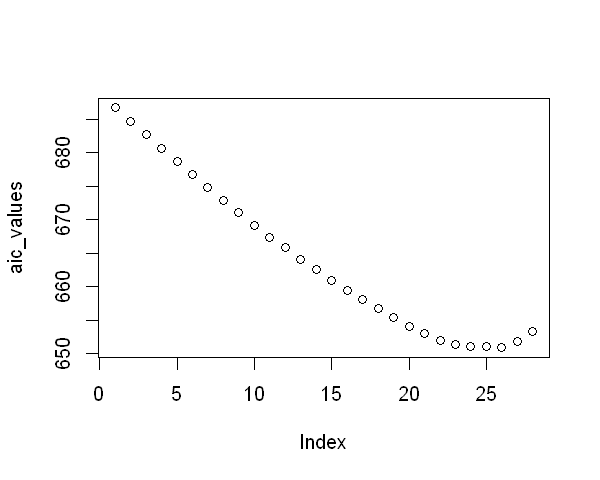

In [26]:
options(repr.plot.width=5, repr.plot.height=4)
plot(aic_values)

Looking at the results of the AIC values it does appear that the model produced at the 24th/26th iteration has the best balance of goodness-of-fit and model complexity. When selecting the final model it's a balance between explainability and performance, so depending on the situation it might make sense to go with that model. However, for this homework I am going to move forward with the final model produced from the backward elimination procedure.

#### Step 4 - Interpret the Model
Now that I have the model reduced to only have variables with a p-value above the significance threshold of 0.05 Iam ready to interpret the model. I'll start with a summary of the final mode. 

In [27]:
summary(credit_model_dummy)


Call:
glm(formula = as.factor(decision) ~ exist_acctA13 + exist_acctA14 + 
    duration + credit_histA32 + credit_histA33 + credit_histA34 + 
    purposeA41 + purposeA410 + purposeA42 + purposeA43 + purposeA49 + 
    credit_amt + savingsA64 + savingsA65 + employ_lenA74 + install_rate + 
    status_sexA93 + debtsA103 + oth_instA143 + houseA152 + houseA153, 
    family = binomial(link = "logit"), data = training_data_dummy)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2556  -0.7047  -0.3471   0.6574   2.6301  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     7.713e-01  5.711e-01   1.351 0.176848    
exist_acctA13  -1.285e+00  4.196e-01  -3.062 0.002197 ** 
exist_acctA14  -1.764e+00  2.474e-01  -7.127 1.02e-12 ***
duration        4.185e-02  1.148e-02   3.645 0.000267 ***
credit_histA32 -7.668e-01  3.642e-01  -2.105 0.035275 *  
credit_histA33 -9.957e-01  4.694e-01  -2.121 0.033887 *  
credit_histA34 -1.475e+00  3.940e-01  

We can see that the model has now been trained only with variables with a significance < 0.05. The AIC value has also been decreased compared to the original model although not as far as it could have been reduced as seen in the plot above. I want to see the coefficients for my final model which I will output below.

In [39]:
# Get model coefficients
print(credit_model_dummy$coefficients)

   (Intercept)  exist_acctA13  exist_acctA14       duration credit_histA32 
  0.7713278405  -1.2849753747  -1.7635294799   0.0418524116  -0.7667749318 
credit_histA33 credit_histA34     purposeA41    purposeA410     purposeA42 
 -0.9957428533  -1.4748464953  -1.6414808117  -1.6630009816  -0.7907875768 
    purposeA43     purposeA49     credit_amt     savingsA64     savingsA65 
 -0.9425797542  -0.9003451974   0.0001233166  -3.4983739271  -1.0313526820 
 employ_lenA74   install_rate  status_sexA93      debtsA103   oth_instA143 
 -0.7401182465   0.3775702623  -0.5886461045  -1.1404630191  -0.7766752938 
     houseA152      houseA153 
 -0.6890182557  -0.9323711974 


Next, I am going to use the testing data to see how well the model predicts the credit 'decision' variable. I found the information about evaluating regression models at https://www.geeksforgeeks.org/plotting-roc-curve-in-r-programming/ very useful for this.

In [29]:
# Error metrix taken from geeksforgeeks
err_metric = function(GFGCM)
{
    GFGTN = GFGCM[1, 1]
    GFGRATE = GFGCM[2, 2]
    FP = GFGCM[1, 2]
    FN = GFGCM[2, 1]
    gfgPrecise = (GFGRATE)/(GFGRATE+FP)
    recall_score = (FP)/(FP+GFGTN)
    f1_score = 2*((gfgPrecise*recall_score)/(gfgPrecise+recall_score))
    accuracy_model = (GFGRATE+GFGTN)/(GFGRATE+GFGTN+FP+FN)
    False_positive_rate = (FP)/(FP+GFGTN)
    False_negative_rate = (FN)/(FN+GFGRATE)
    print(paste("GfgPrecise value of the model: ", round(gfgPrecise, 2)))
    print(paste("Accuracy of the model: ", round(accuracy_model, 2)))
    print(paste("Recall value of the model: ", round(recall_score, 2)))
    print(paste("False Positive rate of the model: ", round(False_positive_rate, 2)))
    print(paste("False Negative rate of the model: ", round(False_negative_rate, 2)))
    print(paste("f1 score of the model: ", round(f1_score, 2)))
}

I will start by creating a confusion matrix that I can use to get various model metrics from

In [38]:
# Create predictions from the regression model on the testing data
pred_log_r <- predict(credit_model_dummy, testing_data_dummy, type = "response")
summary(pred_log_r)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001117 0.078413 0.218238 0.314353 0.541337 0.950794 

In [31]:
# Convert predictions to yes-no answers (1 or 0) and output the confusion matrix
pred_int <- as.integer(pred_log_r > 0.5)
conf_matrix <- table(testing_data_dummy$decision, pred_int)
conf_matrix

   pred_int
      0   1
  1 170  42
  2  41  47

In [32]:
# Get the error metrics
err_metric(conf_matrix)

[1] "GfgPrecise value of the model:  0.53"
[1] "Accuracy of the model:  0.72"
[1] "Recall value of the model:  0.2"
[1] "False Positive rate of the model:  0.2"
[1] "False Negative rate of the model:  0.47"
[1] "f1 score of the model:  0.29"


The model correctly classifies 72% of the points and has an f1 score of 0.29. The F1 score is a metric commonly used in binary classification tasks to evaluate the performance of the model. It is the harmonic mean of precision and recall, providing a single score that balances both measures. A value close to 1 is ideal. and recall:

Next I'll print out the ROC curve and get the AUC value.

Setting levels: control = 0, case = 1
Setting direction: controls < cases


The area under the curve is: 0.667 


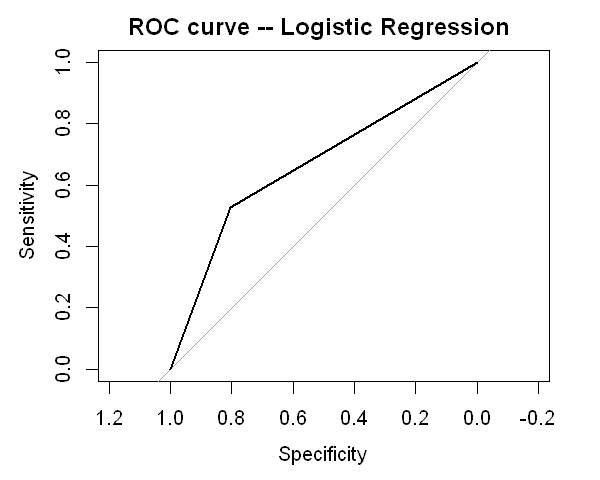

In [33]:
# Print out the ROC curve
roc_values <- roc(pred_int, testing_data_dummy$decision)
cat('The area under the curve is:', round(roc_values$auc, 3), '\n')
plot(roc_values, main="ROC curve -- Logistic Regression ")

#### Step 5 - Create threshold based on part 2 of the question
I know that in this data set, they estimate that incorrectly identifying a bad customer as good, is 5 times worse than incorrectly classifying a good customer as bad. Next, I am going to calculate the total cost of various threshold values to determine a good threshold probability. I am going to do that by iterating through multiple thresholds and calculating and storing the total cost for that threshold. The cost will have the formula:

$$Cost = (FalsePositives * 5) + FalseNegatives$$

In [34]:
# Loop through various threshold values and calculate the cost
thres_values <- seq(0.01, 1, by = 0.01)
cost_results <- c()

for (value in thres_values) {
    pred_int <- as.integer(pred_log_r > value)
    conf_matrix <- table(testing_data_dummy$decision, pred_int)
    
    if(ncol(conf_matrix) > 1) {
        false_neg <- conf_matrix[1,2]
        }
    else {
        false_neg <- 0
        }

    if(nrow(conf_matrix) > 1) {
        false_pos <- conf_matrix[2,1]
        }
    else {
        false_pos <- 0
        }
    
    cost <- (false_pos * 5) + false_neg
    cost_results <- append(cost_results, cost)
    }

min_cost <- which.min(cost_results)
cat('The threshold that produces the lowest cost is', min_cost/100, 'which has a cost of', cost_results[min_cost], '\n')
cat('Compared to the threshold value of 0.5 which had a cost of', cost_results[50], 'the new threshold reduced the total cost by', cost_results[50] - cost_results[min_cost])

The threshold that produces the lowest cost is 0.17 which has a cost of 166 
Compared to the threshold value of 0.5 which had a cost of 247 the new threshold reduced the total cost by 81

Next I want to plot the cost vs. the threshold value to visualize the results

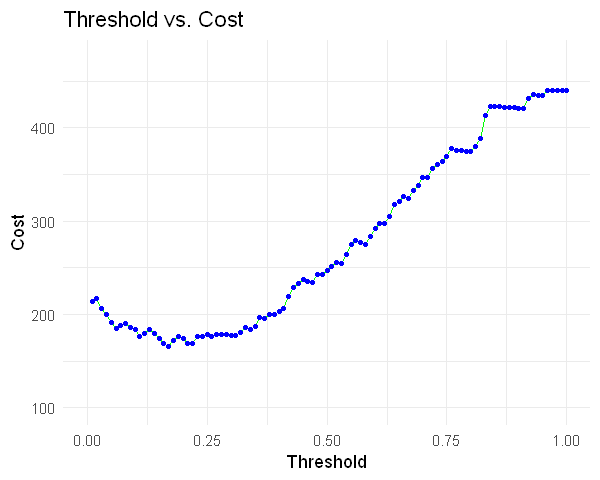

In [35]:
# Create table of thresholds and cost
cost_table <- data.frame(Threshold = thres_values, Cost = cost_results)
ggplot(cost_table, aes(x = Threshold, y = Cost)) +
    geom_line(size = .5, color = "green") +
    geom_point(color = "blue", size = 1) +
    labs(x = "Threshold", y = "Cost", title = "Threshold vs. Cost") +
    xlim(0, 1) +
    ylim(100, 475) +
    theme_minimal()

The graph shows that values around 0.16 to 0.22 provide the lowest cost. Based on the information above, for my model setting a **threshold value of 0.17 provided the best model**. The confusion matrix for this final model is provided below.

In [36]:
pred_int <- as.integer(pred_log_r > 0.2)
conf_matrix <- table(testing_data_dummy$decision, pred_int)
conf_matrix
err_metric(conf_matrix)

   pred_int
      0   1
  1 123  89
  2  17  71

[1] "GfgPrecise value of the model:  0.44"
[1] "Accuracy of the model:  0.65"
[1] "Recall value of the model:  0.42"
[1] "False Positive rate of the model:  0.42"
[1] "False Negative rate of the model:  0.19"
[1] "f1 score of the model:  0.43"
